In [161]:
# Imports
import numpy as np
from numpy import hstack
import matplotlib.pyplot as plt
import random
np.random.seed(1)  
import tensorflow as tf
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import SGD
from sklearn import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import LeakyReLU

from tensorflow.keras.utils import plot_model

# from tensorflow import set_random_seed
np.random.seed(1)

# imports from file
from Functions.Data_mod.Data_load    import * 
from Functions.Data_mod.Data_filters import *
from Functions.Data_mod.Data_parser  import *
from Functions.Data_mod.Data_plot    import *

%matplotlib inline


def norm_by_column(data):
    mins=np.min(data, axis=0)
    maxs=np.max(data, axis=0)
    data=(data-mins)/(maxs-mins)
    return data, mins, maxs


def denorm_by_column(data, mins, maxs):
    return data*(maxs-mins)+mins

In [162]:
# ========= Settings ========================
random.seed(30)
# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'
# Display all columns with pd.head()
pd.set_option('display.max_columns', 50)

In [163]:
# Load in the measurement data
#============= Load file =====================================================
folder = 'Day_03'
date_train = '2019_ 11_ 11_16_25_19_'

df_train = Data_mod_Load(folder, date_train)
df_train_filtered = Data_mod_Filter(df_train, scale=0, qFilter='False', drop='True')


In [347]:

#=============================================================================
# Parsing data
epochs     = 20
n_steps    = 10
features   = 10
output_num = -10 # -1=dz, -8=z # Tracked is present -10=z -3=dz ha drop true
normed_data, mins, maxs=norm_by_column(np.array(df_train_filtered))
X, Y = split_sequences(normed_data, n_steps, features=features, output_num = output_num)

X2, Y2 = split_sequences(normed_data, n_steps, features=features, output_num = 9)

X_train = X[0:int(len(X)*0.6),:,:]
Y_train = Y[0:int(len(Y)*0.6)]
X_test = X[int(len(X)*0.6):int(len(X)*0.7),:,:]
Y_test = Y[int(len(Y)*0.6):int(len(Y)*0.7)]
X_valid  = X[int(len(X)*0.75):,:,:]
Y_valid  = Y[int(len(Y)*0.75):]
D_test = Y2[int(len(Y2)*0.6):int(len(Y2)*0.7)]

'''
plt.plot(Y_test, color = 'red', label='Y-test')
plt.xlabel("Iteration [-]")
plt.ylabel("Position [m]")
plt.legend()
plt.show()
'''

'\nplt.plot(Y_test, color = \'red\', label=\'Y-test\')\nplt.xlabel("Iteration [-]")\nplt.ylabel("Position [m]")\nplt.legend()\nplt.show()\n'

In [274]:
#===== Neural Network Modell ================================================

# the dataset knows the number of features, e.g. 2
n_features = X_train.shape[2]


model = Sequential()
'''
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2,strides=2))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
#model.add(Dropout(0.2))
#model.add(MaxPooling1D(pool_size=2,strides=2))
#model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
#model.add(GlobalAveragePooling1D())

#model.add(Flatten())
#model.add(TimeDistributed(Flatten()))
#model.add(Dense(128, activation='relu'))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
#model.add(LSTM(16, activation='relu', return_sequences=False))
#model.add(LSTM(8,  activation='relu', return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(4, activation='relu', return_sequences=False))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
#model.add(Dense(8, activation='relu'))
'''
#model.add(Flatten())
#model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
#model.add(Dense(512, activation='relu'))
#model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
#model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation=None))
model.compile(optimizer='rmsprop', loss='mean_absolute_error')#SGD(lr=1e-3,momentum=0.9), loss='mse')

In [299]:


#=============================================================================

model.compile(optimizer=SGD(lr=1e-5,decay=1e-5,momentum=0.92), loss='mean_absolute_error')#SGD(lr=1e-3,momentum=0.9), loss='mse')
model.load_weights("08_Linear_Network_weights_abs_64lstm_64_dense_10_input.hdf5")
# fit model
with tf.device('/device:GPU:2'):
    history=model.fit(X_train, Y_train, 
              epochs=50,
              validation_data=(X_valid, Y_valid),
              batch_size=128,
              verbose=2,
              shuffle= True)


    plt.plot(history.history['loss'],     label='train')
    plt.plot(history.history['val_loss'], label='valid')
    plt.legend()
    plt.show()

    model.summary()


Train on 30958 samples, validate on 12900 samples
Epoch 1/50
30958/30958 - 4s - loss: 0.0934 - val_loss: 0.0883
Epoch 2/50
30958/30958 - 3s - loss: 0.0933 - val_loss: 0.0874
Epoch 3/50
30958/30958 - 3s - loss: 0.0933 - val_loss: 0.0874
Epoch 4/50
30958/30958 - 3s - loss: 0.0932 - val_loss: 0.0876
Epoch 5/50
30958/30958 - 3s - loss: 0.0932 - val_loss: 0.0880
Epoch 6/50
30958/30958 - 3s - loss: 0.0932 - val_loss: 0.0877
Epoch 7/50
30958/30958 - 3s - loss: 0.0932 - val_loss: 0.0880
Epoch 8/50
30958/30958 - 3s - loss: 0.0932 - val_loss: 0.0880
Epoch 9/50
30958/30958 - 3s - loss: 0.0932 - val_loss: 0.0878
Epoch 10/50
30958/30958 - 3s - loss: 0.0932 - val_loss: 0.0882
Epoch 11/50
30958/30958 - 3s - loss: 0.0932 - val_loss: 0.0877
Epoch 12/50
30958/30958 - 3s - loss: 0.0932 - val_loss: 0.0884
Epoch 13/50
30958/30958 - 3s - loss: 0.0932 - val_loss: 0.0884
Epoch 14/50
30958/30958 - 3s - loss: 0.0932 - val_loss: 0.0881
Epoch 15/50
30958/30958 - 3s - loss: 0.0932 - val_loss: 0.0877
Epoch 16/50
30

KeyboardInterrupt: 

In [339]:
# ======== Save model ========================
# save model and architecture to single file
model.save("08_Linear_Network_weights_abs.hdf5")

#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#model.load_weights("08_Linear_Network_weights.hdf5")
with tf.device('/device:GPU:2'):
    Y_pred = model.predict(X_test, batch_size=1024, verbose=2)


5159/1 - 0s


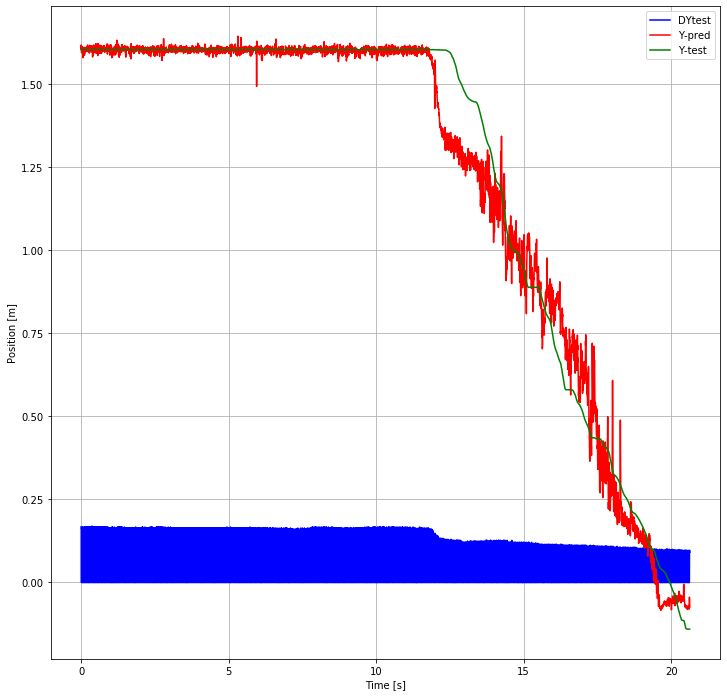

In [358]:
plt.figure(figsize=(12,12))
plt.plot(np.arange(0,len(D_test)*0.004,0.004),denorm_by_column(D_test,mins[9],maxs[9]), color = 'blue', label='DYtest')
plt.plot(np.arange(0,len(Y_pred)*0.004,0.004),denorm_by_column(Y_pred,mins[output_num],maxs[output_num]), color = 'red', label='Y-pred')
plt.plot(np.arange(0,len(Y_test)*0.004,0.004),denorm_by_column(Y_test,mins[output_num],maxs[output_num]), color = 'green', label='Y-test')
#plt.plot(np.arange(0,len(D_test)*0.004,0.004),denorm_by_column(D_test,mins[9],maxs[9]), color = 'blue', label='DYtest')

plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.grid()
plt.legend()
plt.show()

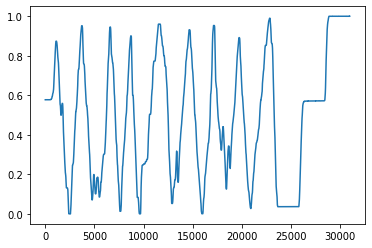

In [334]:
plt.plot(Y_train)

In [335]:
denorm_by_column(0.0920,mins[output_num],maxs[output_num])

0.01871703999999999

In [336]:
np.average(np.abs(Y_pred-Y_test))

0.31284766497746574

In [337]:
denorm_by_column(0.17704888266412894,mins[output_num],maxs[output_num])

0.1671588083354907

5159/1 - 0s
Mean abs error:  0.0416624824892224
Max abs error:  0.27665004355378153


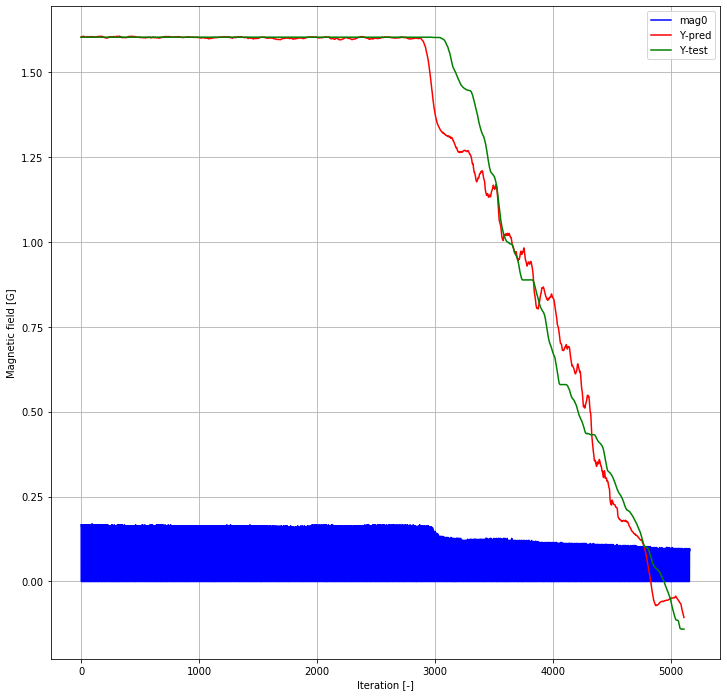

In [378]:
with tf.device('/device:GPU:2'):
    Y_valpred = model.predict(X_test, batch_size=1024, verbose=2)
plt.figure(figsize=(12,12))
N=50
Y_filtered=np.convolve(Y_valpred.flatten(), np.ones((N,))/N, mode='same')
denorm1=denorm_by_column(Y_filtered.reshape(-1,)[49:],mins[output_num],maxs[output_num])
denorm2=denorm_by_column(Y_test.reshape(-1,)[49:],mins[output_num],maxs[output_num])
print('Mean abs error: ',np.average(np.abs(denorm1-denorm2)))
print('Max abs error: ',np.max(np.abs(denorm1-denorm2)))

plt.plot(denorm_by_column(D_test,mins[9],maxs[9]), color = 'blue', label='mag0')
plt.plot(denorm_by_column(Y_filtered[49:],mins[output_num],maxs[output_num]), color = 'red', label='Y-pred')
plt.plot(denorm_by_column(Y_test[49:],mins[output_num],maxs[output_num]), color = 'green', label='Y-test')
plt.xlabel("Iteration [-]")
plt.ylabel("Magnetic field [G]")
plt.grid()
plt.legend()
plt.show()

In [352]:
df_train_filtered['mag0'].max()

0.152

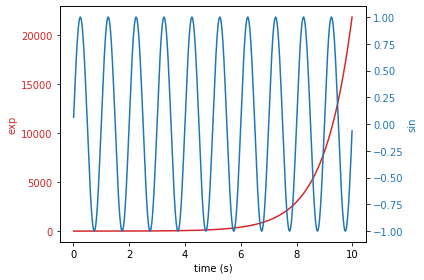

In [360]:
# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

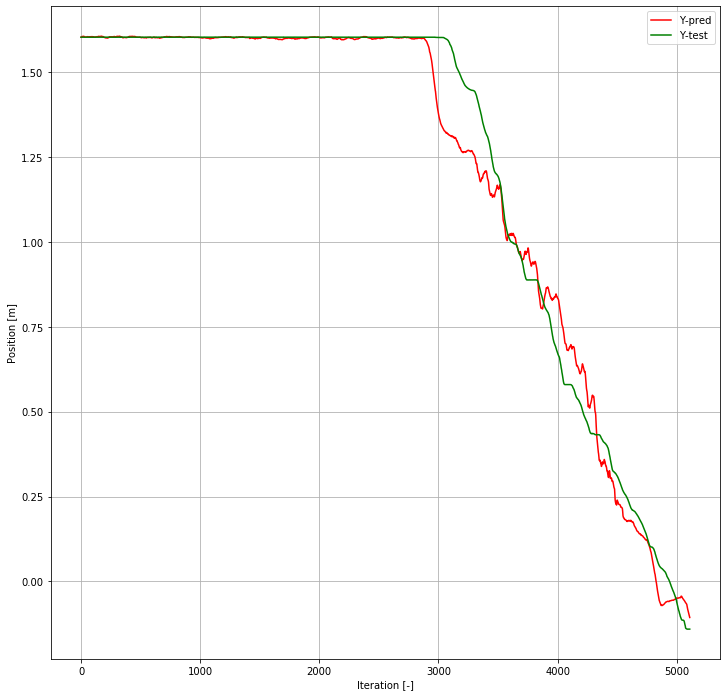

In [373]:

plt.figure(figsize=(12,12))
N=50
Y_filtered=np.convolve(Y_valpred.flatten(), np.ones((N,))/N, mode='same')
denorm1=denorm_by_column(Y_filtered.reshape(-1,)[49:],mins[output_num],maxs[output_num])
denorm2=denorm_by_column(Y_test.reshape(-1,)[49:],mins[output_num],maxs[output_num])

plt.plot(denorm_by_column(Y_filtered[49:],mins[output_num],maxs[output_num]), color = 'red', label='Y-pred')
plt.plot(denorm_by_column(Y_test[49:],mins[output_num],maxs[output_num]), color = 'green', label='Y-test')
plt.xlabel("Iteration [-]")
plt.ylabel("Position [m]")
plt.grid()
plt.legend()
plt.show()